In [101]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


## Import Dependencies

In [102]:
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten
from tensorflow.keras.models import Model

## Open Data

In [103]:
# Read in dataframe
train_df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header = None)
val_df = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", header = None)

In [104]:
# View first 5 rows 
train_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [105]:
# View the number of rows and columns
num_rows, num_cols = train_df.shape
print(f"The training data has {num_rows} rows and {num_cols} columns")

The training data has 74682 rows and 4 columns


In [106]:
val_df.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## Data Preparation

In [107]:
# Change the column names
train_df.columns = ["Tweet ID", "Entity", "Sentiment", "Tweet Content"]
val_df.columns = ["Tweet ID", "Entity", "Sentiment", "Tweet Content"]

In [108]:
# View the data for any missing values
train_df.isnull().sum(axis = 0) # There are missing tweets
train_df.dropna(inplace = True) # Drop missing tweets, cannot infer them

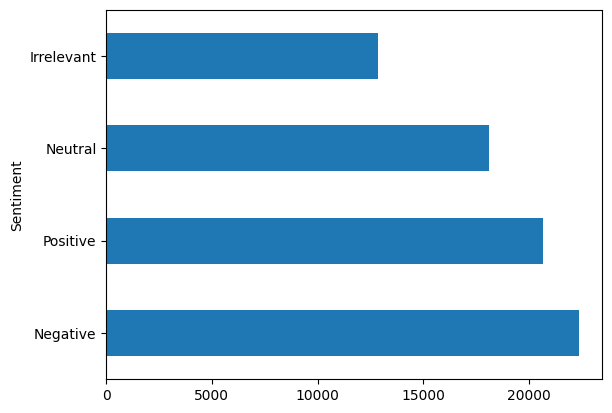

In [109]:
# View class distributions
train_df["Sentiment"].value_counts().plot(kind = "barh") # There are discrepencies in class, may need to be addressed
plt.show()

## Exploratory Data Analysis

In [110]:
# Select 3 example tweets of each class
CLASSES = train_df["Sentiment"].unique()
for sentiment in CLASSES:
    print(sentiment)
    print(train_df[train_df["Sentiment"] == sentiment]["Tweet Content"].sample(3))
    print()

Positive
39395                 Thank you For..
4542     THE TRAILER BRO IM EXCITED  
13595                             can
Name: Tweet Content, dtype: object

Neutral
14164    Virtus. Pro kept to the first line in the grou...
19284    I just earned the [Deepwind Gorge Perfection] ...
26721    Going live!. Back to ancient Greece with assas...
Name: Tweet Content, dtype: object

Negative
56770    3 RhandlerR  great game you got 🤣.  joke fix i...
57087    @Rainbow6Game so I get a connection failure fr...
13128    @NBA2K so I just got notified that I completed...
Name: Tweet Content, dtype: object

Irrelevant
10796    Xbox Office: E3 IS CANCELE, WHAT ARE GONDO TO ...
59095    Ft freelance model, mua, stylist, jewelry mode...
21211    Tonight at 19: 00 our CS: GO Team Anger Manage...
Name: Tweet Content, dtype: object



## Data Preprocessing

In [111]:
# Change the labels into sparse categorical
label_encoder = LabelEncoder()
train_df["Sentiment"] = label_encoder.fit_transform(train_df["Sentiment"])

# Do the same to validation data
val_df["Sentiment"] = label_encoder.fit_transform(val_df["Sentiment"])

In [112]:
label_encoder.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

## Data Modeling

### Bag-of-words

In [113]:
# Vectorize the tweets
vec = TfidfVectorizer(stop_words = "english")

# Training Data
X_train = vec.fit_transform(train_df["Tweet Content"])
y_train = train_df["Sentiment"].to_numpy()

# Validation Data
X_val = vec.transform(val_df["Tweet Content"])
y_val = val_df["Sentiment"].to_numpy()

In [114]:
def train_test_pipeline(model, X_train, X_test, y_train, y_test):
    # Train model on train data
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    total_train_time = end_time - start_time

    # Training Accuracy
    y_train_pred = model.predict(X_train)

    # Make Predictions on Test Data
    y_pred = model.predict(X_test)

    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Plot a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1', "Predicted 2", "Predicted 3"],
                yticklabels=['Actual 0', 'Actual 1', "Actual 2", "Actual 3"])
    plt.title('Confusion Matrix (Test Set)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"Train Time : {total_train_time:3f} seconds")
    print(f"Train Accuracy: {train_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")
    print("\nClassification Report:\n", classification_rep)
    return round(total_train_time, 3), round(train_accuracy, 3), round(test_accuracy, 3)

In [115]:
# Dictionary to compare models
model_comparison_dict = {
    "Model": [],
    "Train Time": [],
    "Train Accuracy": [],
    "Validation Accuracy": []
}

### Naive Bayes

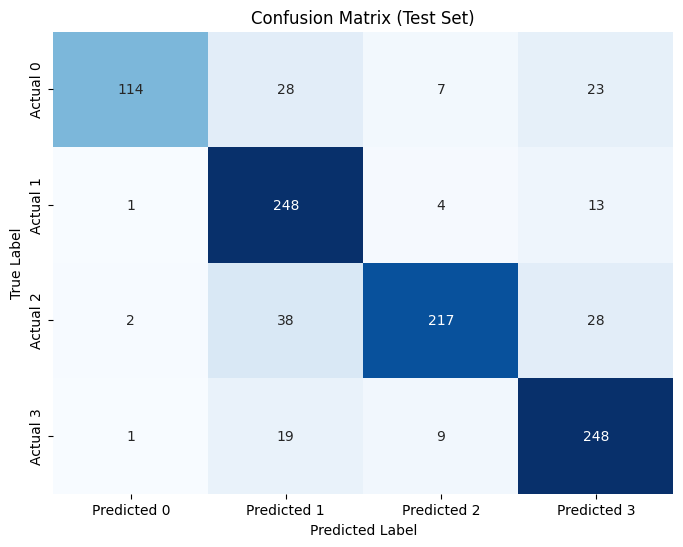

Train Time : 0.023203 seconds
Train Accuracy: 0.803
Test Accuracy: 0.827

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.66      0.79       172
           1       0.74      0.93      0.83       266
           2       0.92      0.76      0.83       285
           3       0.79      0.90      0.84       277

    accuracy                           0.83      1000
   macro avg       0.86      0.81      0.82      1000
weighted avg       0.85      0.83      0.83      1000



In [116]:
# Naive Bayes Classifier
nb_classifier = MultinomialNB()

# Train classifier
nb_train_time, nb_train_acc, nb_val_acc = train_test_pipeline(nb_classifier, X_train, X_val, y_train, y_val)

# Append Model Output to Comparison Dictionary
model_comparison_dict["Model"].append("Naive Bayes")
model_comparison_dict["Train Time"].append(nb_train_time)
model_comparison_dict["Train Accuracy"].append(nb_train_acc)
model_comparison_dict["Validation Accuracy"].append(nb_val_acc)

### Support Vector Machine (SVM)

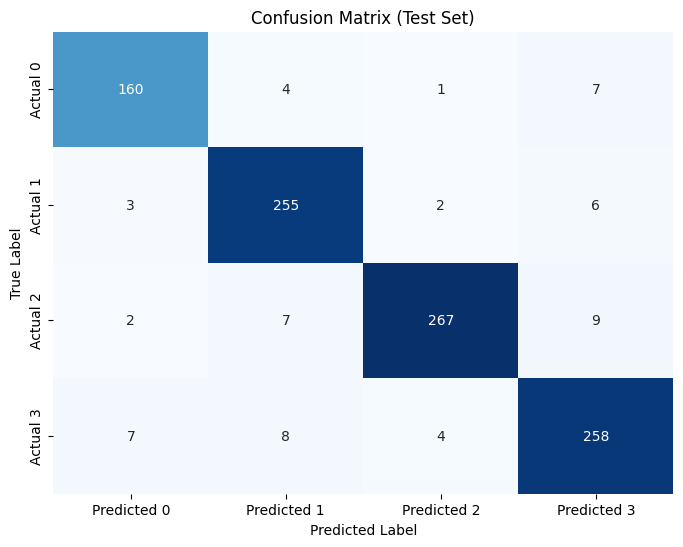

Train Time : 1214.096248 seconds
Train Accuracy: 0.906
Test Accuracy: 0.940

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       172
           1       0.93      0.96      0.94       266
           2       0.97      0.94      0.96       285
           3       0.92      0.93      0.93       277

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [117]:
# SVM Classifier
svm_classifier = SVC(kernel='linear')

# Train Classifier
svm_train_time, svm_train_acc, svm_val_acc = train_test_pipeline(svm_classifier, X_train, X_val, y_train, y_val)

# Append Model Output to Comparison Dictionary
model_comparison_dict["Model"].append("SVM")
model_comparison_dict["Train Time"].append(svm_train_time)
model_comparison_dict["Train Accuracy"].append(svm_train_acc)
model_comparison_dict["Validation Accuracy"].append(svm_val_acc)

### Decision Tree

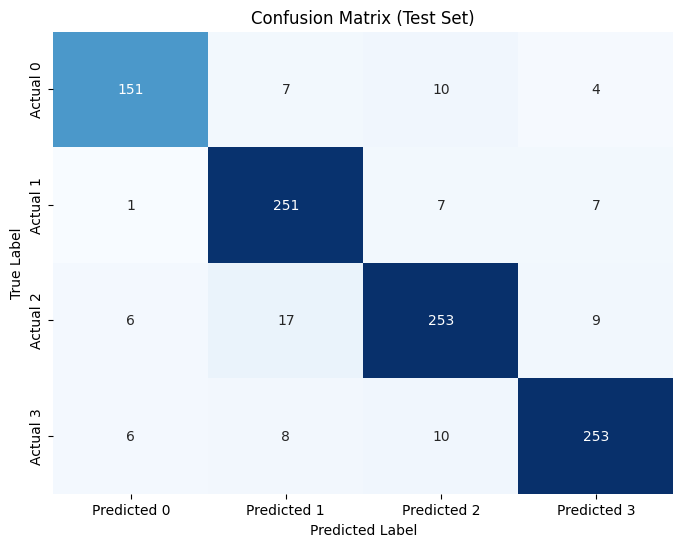

Train Time : 33.221555 seconds
Train Accuracy: 0.972
Test Accuracy: 0.908

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       172
           1       0.89      0.94      0.91       266
           2       0.90      0.89      0.90       285
           3       0.93      0.91      0.92       277

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [118]:
# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state = 42)

# Train Classifier
dt_train_time, dt_train_acc, dt_val_acc = train_test_pipeline(dt_classifier, X_train, X_val, y_train, y_val)

# Append Model Output to Comparison Dictionary
model_comparison_dict["Model"].append("Decision Tree")
model_comparison_dict["Train Time"].append(dt_train_time)
model_comparison_dict["Train Accuracy"].append(dt_train_acc)
model_comparison_dict["Validation Accuracy"].append(dt_val_acc)

### Random Forest

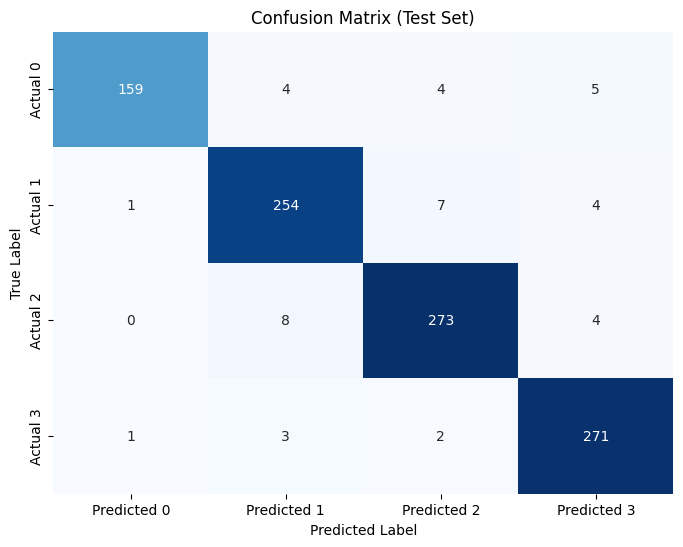

Train Time : 317.433572 seconds
Train Accuracy: 0.972
Test Accuracy: 0.957

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       172
           1       0.94      0.95      0.95       266
           2       0.95      0.96      0.96       285
           3       0.95      0.98      0.97       277

    accuracy                           0.96      1000
   macro avg       0.96      0.95      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [119]:
# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state = 42)

# Train Classifier
rf_train_time, rf_train_acc, rf_val_acc = train_test_pipeline(rf_classifier, X_train, X_val, y_train, y_val)

# Append Model Output to Comparison Dictionary
model_comparison_dict["Model"].append("Random Forest")
model_comparison_dict["Train Time"].append(rf_train_time)
model_comparison_dict["Train Accuracy"].append(rf_train_acc)
model_comparison_dict["Validation Accuracy"].append(rf_val_acc)

### XGBoost

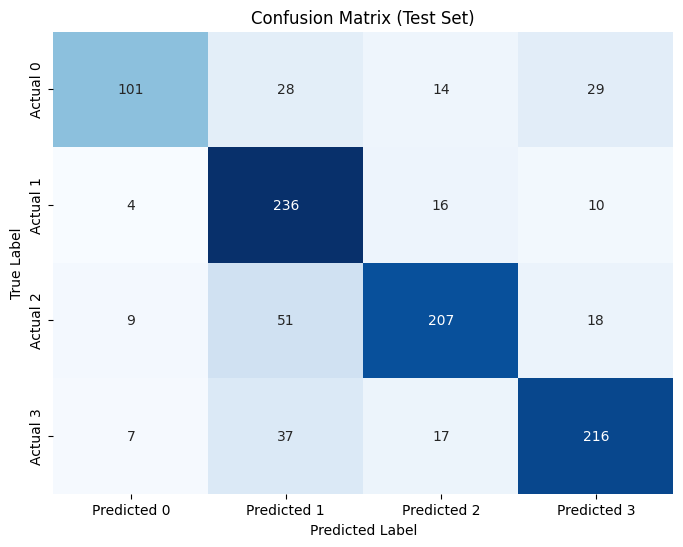

Train Time : 88.302924 seconds
Train Accuracy: 0.703
Test Accuracy: 0.760

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.59      0.69       172
           1       0.67      0.89      0.76       266
           2       0.81      0.73      0.77       285
           3       0.79      0.78      0.79       277

    accuracy                           0.76      1000
   macro avg       0.78      0.75      0.75      1000
weighted avg       0.77      0.76      0.76      1000



In [120]:
# XGBoost Classifier
xgb_classifier = XGBClassifier()

# Train Classifier
xgb_train_time, xgb_train_acc, xgb_val_acc = train_test_pipeline(xgb_classifier, X_train, X_val, y_train, y_val)

# Append Model Output to Comparison Dictionary
model_comparison_dict["Model"].append("XGBoost")
model_comparison_dict["Train Time"].append(xgb_train_time)
model_comparison_dict["Train Accuracy"].append(xgb_train_acc)
model_comparison_dict["Validation Accuracy"].append(xgb_val_acc)

### Deep Learning Methods

In [121]:
# Use tensorflow tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df["Tweet Content"])
vocab_size = len(tokenizer.word_index) + 1

In [122]:
# Tensorflow padding
train_sequences = tokenizer.texts_to_sequences(train_df["Tweet Content"])
val_sequences = tokenizer.texts_to_sequences(val_df["Tweet Content"])

# Padding and Create Partitions
max_sequence_length = 100
X_train = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
y_train = train_df["Sentiment"].to_numpy()
X_val = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')
y_val = val_df["Sentiment"].to_numpy()

In [123]:
def build_model(vocab_size, sequence_length, embedding_dim):
    input_sequence = Input(shape = (sequence_length,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim = embedding_dim) (input_sequence)
    flattened_layer = Flatten() (embedding_layer)
    dense_layer = Dense(128, activation="relu") (flattened_layer)
    output_layer = Dense(4, activation = "softmax") (dense_layer)
    
    model = Model(inputs = input_sequence, outputs = output_layer)
    return model

In [124]:
# Creating the Model
sequence_length = X_train.shape[1]
embedding_dim = 64
model = build_model(vocab_size = vocab_size, sequence_length = sequence_length, embedding_dim = embedding_dim)

In [125]:
# Optimizer and Loss Function
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

In [126]:
# Compile the model
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ["accuracy"])

In [127]:
# Add Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor = "val_loss",
                    patience = 3,
                    verbose = 1,
                    mode = "min",
                    restore_best_weights = True)

In [128]:
start_time = time.time()
history = model.fit(X_train, y_train, batch_size = 1024, epochs=20, validation_data=(X_val, y_val), callbacks = [early_stopping])
end_time = time.time()

dl_time = end_time - start_time

Epoch 1/20
73/73 [==============================] - 6s 76ms/step - loss: 1.2332 - accuracy: 0.4576 - val_loss: 0.8743 - val_accuracy: 0.6570
Epoch 2/20
73/73 [==============================] - 5s 75ms/step - loss: 0.7052 - accuracy: 0.7421 - val_loss: 0.3089 - val_accuracy: 0.9250
Epoch 3/20
73/73 [==============================] - 5s 73ms/step - loss: 0.3356 - accuracy: 0.8944 - val_loss: 0.1284 - val_accuracy: 0.9690
Epoch 4/20
73/73 [==============================] - 5s 72ms/step - loss: 0.1890 - accuracy: 0.9406 - val_loss: 0.0847 - val_accuracy: 0.9750
Epoch 5/20
73/73 [==============================] - 5s 72ms/step - loss: 0.1322 - accuracy: 0.9571 - val_loss: 0.0648 - val_accuracy: 0.9800
Epoch 6/20
73/73 [==============================] - 5s 72ms/step - loss: 0.1070 - accuracy: 0.9637 - val_loss: 0.0549 - val_accuracy: 0.9850
Epoch 7/20
73/73 [==============================] - 5s 71ms/step - loss: 0.0893 - accuracy: 0.9685 - val_loss: 0.0517 - val_accuracy: 0.9830
Epoch 8/20
73

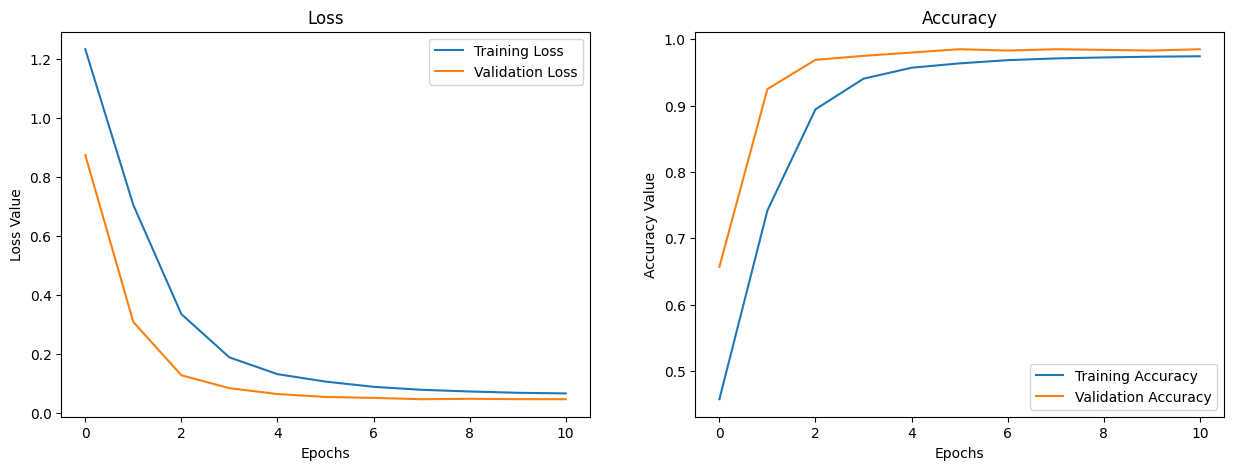

In [129]:
# Plot accuracy and loss curves
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axes[0].plot(history.history["loss"], label = "Training Loss")
axes[0].plot(history.history["val_loss"], label = "Validation Loss")
axes[1].plot(history.history["accuracy"], label = "Training Accuracy")
axes[1].plot(history.history["val_accuracy"], label = "Validation Accuracy")

axes[0].set_title("Loss")
axes[0].set_ylabel("Loss Value")
axes[0].set_xlabel("Epochs")
axes[1].set_title("Accuracy")
axes[1].set_ylabel("Accuracy Value")
axes[1].set_xlabel("Epochs")

axes[0].legend()
axes[1].legend()
plt.show()

In [130]:
# Get Training Accuracy of model
dl_train_acc = model.evaluate(X_train, y_train)[1]

# Get Validation accuracy of model
dl_val_acc = model.evaluate(X_val, y_val)[1]

32/32 [==============================] - 0s 3ms/step - loss: 0.0472 - accuracy: 0.9850


In [131]:
# Append Model Output to Comparison Dictionary
model_comparison_dict["Model"].append("Deep Learning")
model_comparison_dict["Train Time"].append(dl_time)
model_comparison_dict["Train Accuracy"].append(dl_train_acc)
model_comparison_dict["Validation Accuracy"].append(dl_val_acc)

## Model Comparison

In [132]:
model_comparison_df = pd.DataFrame.from_dict(model_comparison_dict)

In [133]:
pd.melt(model_comparison_df, id_vars = ["Model"], value_vars = ["Train Accuracy", "Validation Accuracy"])

,Model,variable,value
0,Naive Bayes,Train Accuracy,0.803000
1,SVM,Train Accuracy,0.906000
2,Decision Tree,Train Accuracy,0.972000
3,Random Forest,Train Accuracy,0.972000
4,XGBoost,Train Accuracy,0.703000
5,Deep Learning,Train Accuracy,0.972999
6,Naive Bayes,Validation Accuracy,0.827000
7,SVM,Validation Accuracy,0.940000
8,Decision Tree,Validation Accuracy,0.908000
9,Random Forest,Validation Accuracy,0.957000


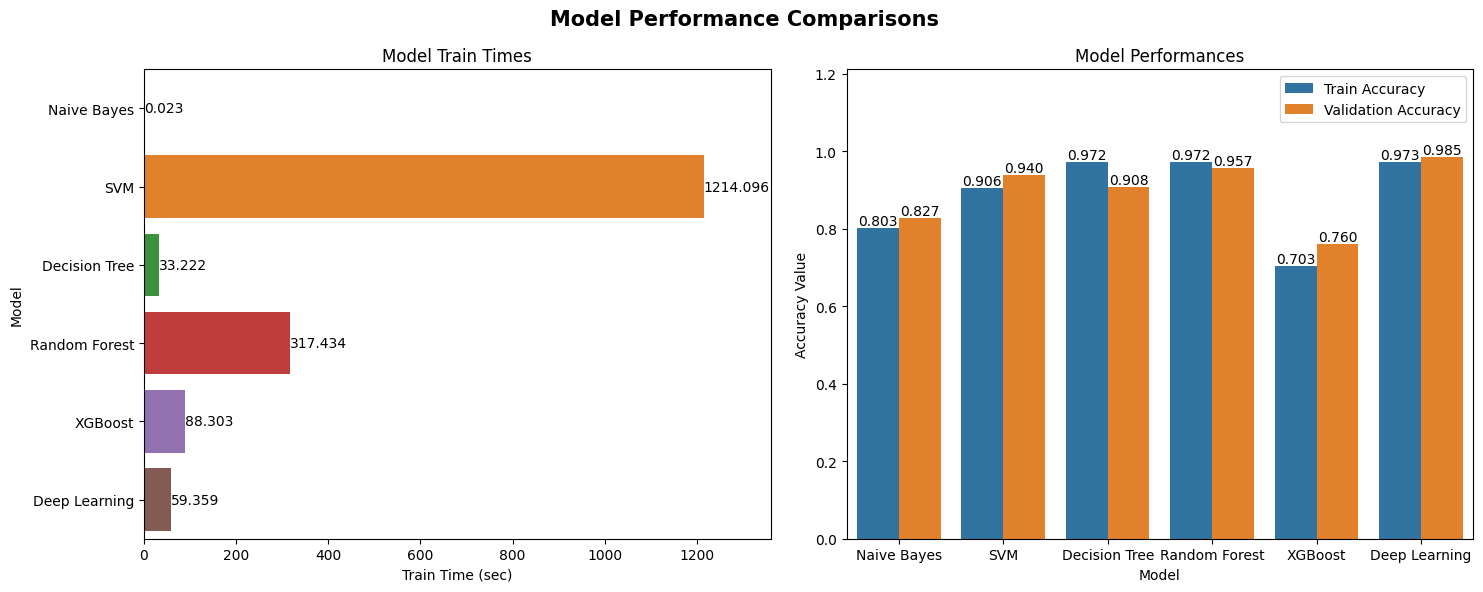

In [134]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))

sns.barplot(data = model_comparison_df, y = "Model", x = "Train Time", orient = "h", ax = axes[0])
for i in axes[0].containers:
    axes[0].bar_label(i, fmt = "%.3f")
axes[0].margins(x=0.12)
axes[0].set_xlabel("Train Time (sec)")
axes[0].set_title("Model Train Times")

model_comparison_melt = pd.melt(model_comparison_df, id_vars = ["Model"], value_vars = ["Train Accuracy", "Validation Accuracy"])
sns.barplot(data = model_comparison_melt, x = "Model", y = "value", hue = "variable", ax = axes[1])
axes[1].legend(title = "", bbox_to_anchor=(1, 1))
axes[1].set_ylabel("Accuracy Value")
axes[1].set_title("Model Performances")
for i in axes[1].containers:
    axes[1].bar_label(i, fmt = "%.3f")
axes[1].margins(y=0.23)    

plt.suptitle("Model Performance Comparisons", fontsize = 15, fontweight = "bold")
plt.tight_layout()
plt.show()